In [314]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
import timm

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm

from PIL import Image

In [254]:
class MemeOrCatDataSet(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes


class efficientnet_b0(nn.Module):
    def __init__(self, num_classes):
        super(MemeClassifier, self).__init__()

        self.base_model = timm.create_model('efficientnet_b0', pretrained=False)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        self.classifier = nn.Linear(1280, num_classes)

    def forward(self, x):
        x = self.features(x)
        output = self.classifier(x)
        return output


class MemeClassifier(nn.Module):
    def __init__(self, num_features=30000, h1=30, h2=20, features=2):
        super(MemeClassifier, self).__init__()
        self.fc1 = nn.Linear(num_features, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.out = nn.Linear(h2, features)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x



In [280]:
transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor()
])


train_folder = MemeOrCatDataSet(data_dir="../MemeDataBase/train/", transform=transform)
valid_folder = MemeOrCatDataSet(data_dir="../MemeDataBase/valid", transform=transform)
# test_folder = MemeOrCatDataSet(data_dir="./CardsDataSet/test", transform=transform)

train_loader = DataLoader(train_folder, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_folder, batch_size=32, shuffle=False)
# test_loader = DataLoader(test_folder, batch_size=32, shuffle=False)

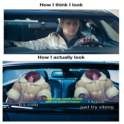

In [266]:
transform_test = transforms.Compose([
    transforms.Resize((124, 124))
])

image = Image.open("../MemeDataBase/valid/Meme/196blwl.jpeg")
transform_test(image)

In [278]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# create model instance
model = MemeClassifier(features=2)
model.to(device)

# loss Function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [283]:
epochs = 20
losses = []

for i in range(epochs):
    model.train()
    for images, labels in tqdm(train_loader, desc='Training Data'):
        images, labels = images.to(device), labels.to(device)
        y_pred = model.forward(images)
        loss = criterion(y_pred, labels)
        losses.append(loss.cpu().detach().numpy())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if i % 10 == 0:
        print(f"Epoch : {i} and loss {loss}")

Training Data:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 0 and loss 0.48611003160476685


Training Data:   0%|          | 0/8 [00:00<?, ?it/s]

Training Data:   0%|          | 0/8 [00:00<?, ?it/s]

Training Data:   0%|          | 0/8 [00:00<?, ?it/s]

Training Data:   0%|          | 0/8 [00:00<?, ?it/s]

Training Data:   0%|          | 0/8 [00:00<?, ?it/s]

Training Data:   0%|          | 0/8 [00:00<?, ?it/s]

Training Data:   0%|          | 0/8 [00:00<?, ?it/s]

Training Data:   0%|          | 0/8 [00:00<?, ?it/s]

Training Data:   0%|          | 0/8 [00:00<?, ?it/s]

Training Data:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 10 and loss 0.3992053270339966


Training Data:   0%|          | 0/8 [00:00<?, ?it/s]

Training Data:   0%|          | 0/8 [00:00<?, ?it/s]

Training Data:   0%|          | 0/8 [00:00<?, ?it/s]

Training Data:   0%|          | 0/8 [00:00<?, ?it/s]

Training Data:   0%|          | 0/8 [00:00<?, ?it/s]

Training Data:   0%|          | 0/8 [00:00<?, ?it/s]

Training Data:   0%|          | 0/8 [00:00<?, ?it/s]

Training Data:   0%|          | 0/8 [00:00<?, ?it/s]

Training Data:   0%|          | 0/8 [00:00<?, ?it/s]

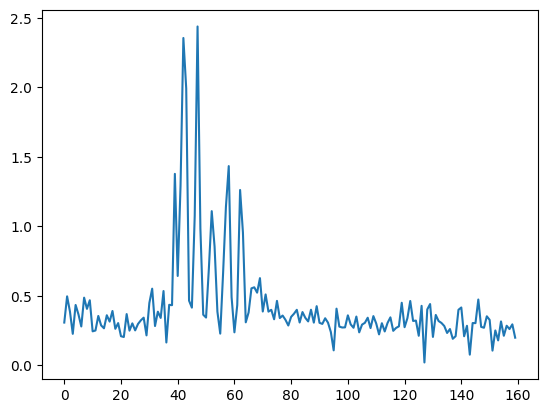

In [292]:
fig, ax = plt.subplots()
ax = sns.lineplot([float(arr) for arr in losses])
plt.show()

In [240]:
num_epoch = 5
train_losses, val_losses = [], []

model.to(device)

for epoch in range(num_epoch):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training Model'):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(valid_loader, desc='Validation Loop'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
    val_loss = running_loss / len(valid_loader.dataset)
    val_losses.append(val_loss)

    # print EPOCH
    print(f"Epch {epoch+1}/{num_epoch} - Train Loss {train_loss}, valid_loss {val_loss}")

Training Model:   0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\timmi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\PIL\Image.py:3186: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Validation Loop:   0%|          | 0/4 [00:00<?, ?it/s]

Epch 1/20 - Train Loss 1.4254461500955664, valid_loss 0.7395701505699936


Training Model:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/4 [00:00<?, ?it/s]

Epch 2/20 - Train Loss 0.7220247014709141, valid_loss 0.7234765400691908


Training Model:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/4 [00:00<?, ?it/s]

Epch 3/20 - Train Loss 0.6552066497180773, valid_loss 0.6903672717055496


Training Model:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/4 [00:00<?, ?it/s]

Epch 4/20 - Train Loss 0.6503187910370205, valid_loss 0.7403114693505424


Training Model:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/4 [00:00<?, ?it/s]

Epch 5/20 - Train Loss 0.6191695467285488, valid_loss 0.6975313656184138


Training Model:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/4 [00:00<?, ?it/s]

Epch 6/20 - Train Loss 0.6098062618919041, valid_loss 0.6989625424754863


Training Model:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/4 [00:00<?, ?it/s]

Epch 7/20 - Train Loss 0.5874609838361325, valid_loss 0.7086480758628066


Training Model:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/4 [00:00<?, ?it/s]

Epch 8/20 - Train Loss 0.6622049391269684, valid_loss 0.7101754716464451


Training Model:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/4 [00:00<?, ?it/s]

Epch 9/20 - Train Loss 0.5649438158325527, valid_loss 0.7021041962565208


Training Model:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/4 [00:00<?, ?it/s]

Epch 10/20 - Train Loss 0.5574777919313182, valid_loss 0.7410832296828834


Training Model:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/4 [00:00<?, ?it/s]

Epch 11/20 - Train Loss 0.5346117962961612, valid_loss 0.7271970480072255


Training Model:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/4 [00:00<?, ?it/s]

Epch 12/20 - Train Loss 0.4982116673303687, valid_loss 0.7312734990703816


Training Model:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/4 [00:00<?, ?it/s]

Epch 13/20 - Train Loss 0.45156182569006215, valid_loss 0.752753246803673


Training Model:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/4 [00:00<?, ?it/s]

Epch 14/20 - Train Loss 0.4805911504704019, valid_loss 0.8983499055006066


Training Model:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/4 [00:00<?, ?it/s]

Epch 15/20 - Train Loss 0.523888841919277, valid_loss 0.709394596060928


Training Model:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/4 [00:00<?, ?it/s]

Epch 16/20 - Train Loss 0.5285363453885783, valid_loss 0.8085004237233376


Training Model:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/4 [00:00<?, ?it/s]

Epch 17/20 - Train Loss 0.4837649879248246, valid_loss 0.7389202349039973


Training Model:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/4 [00:00<?, ?it/s]

Epch 18/20 - Train Loss 0.4813108301681021, valid_loss 0.8359941031251635


Training Model:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/4 [00:00<?, ?it/s]

Epch 19/20 - Train Loss 0.4472858263098675, valid_loss 0.8579988418793192


Training Model:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/4 [00:00<?, ?it/s]

Epch 20/20 - Train Loss 0.4224413954693338, valid_loss 0.7783358680958651


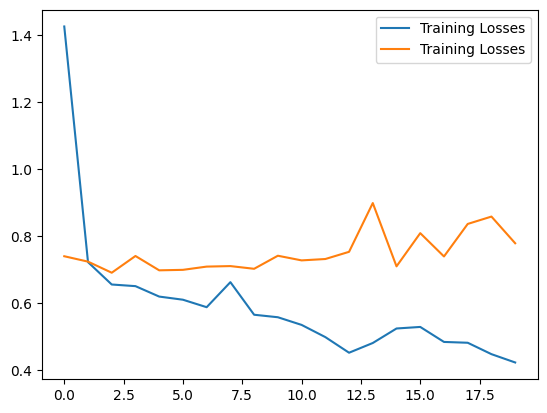

In [241]:
fig, ax = plt.subplots()

ax = sns.lineplot(train_losses, label='Training Losses')
ax = sns.lineplot(val_losses, label='Training Losses')

plt.show()

In [324]:

# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(10, 4))
    
    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")
    
    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()


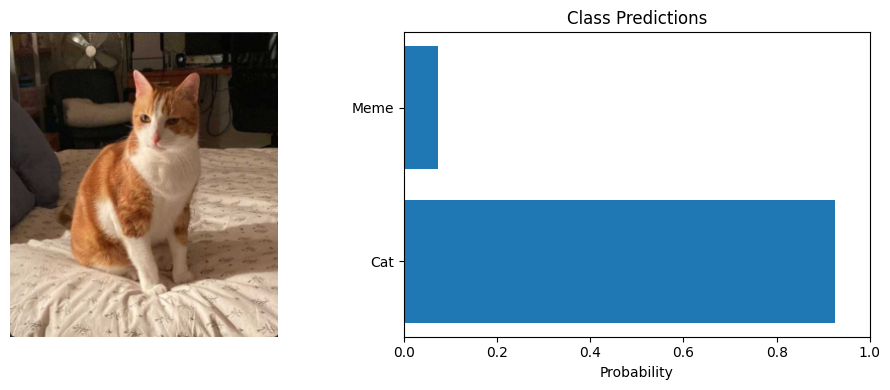

In [325]:
# Example usage
test_image = "../MemeDataBase/Fun/Screenshot 2024-01-16 140800.png"
transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor()
])

original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, device)

# Assuming dataset.classes gives the class names
class_names = train_folder.classes 
visualize_predictions(original_image, probabilities, class_names)